### Anomaly detection and deep dive on Telecom data

**Problem Statement**: Detect anomalies in the nodes and protocols across all the markets

###### import packages

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
from rstl import STL

##### load data

In [8]:
duration = pd.read_excel('DurationAndPayloadByMarketAndNodeAndProtocol.xlsx',sheet_name=0, header=1,skip_rows=1,usecols='A:G',)

In [9]:
df = duration[pd.notnull(duration['RATIO(%)'])]
df = df.groupby(['DAY','MARKET']).aggregate({'NON-LTE_SUM':sum,'ALL_RAT_TYPE_SUM':sum}).reset_index()
df['ratio'] = (df['NON-LTE_SUM']/df['ALL_RAT_TYPE_SUM'])*100
markets = ['LONG ISLAND', 'LOS ANGELES', 'SEATTLE', 'SOUTH CAROLINA']
li_df, la_df, se_df, sc_df = [df[df['MARKET']==market] for market in markets]

In [10]:
national_df = df.groupby(['DAY']).aggregate({'NON-LTE_SUM':sum,'ALL_RAT_TYPE_SUM':sum}).reset_index()
national_df['ratio'] = (national_df['NON-LTE_SUM']/national_df['ALL_RAT_TYPE_SUM'])*100

In [18]:
data  = national_df['ratio'].values

In [22]:
def stl_algo(leakage_ratio, seasonality='weekly'):
    ts = leakage_ratio

    if seasonality == 'weekly':
        freq = 7

    stl = STL(ts, freq, "periodic")

    trend = stl.trend
    seasonal = stl.seasonal
    residual = stl.remainder
    
    return trend, seasonal, residual
    

#### PROTOCOL Level

In [8]:
df.head()

,DAY,PROTOCOL,NON-LTE_SUM,ALL_RAT_TYPE_SUM,ratio
0,2018-08-01,120sports,7.100790e+02,1.959680e+04,3.623443
1,2018-08-01,8tracks,5.834756e+03,2.159086e+05,2.702419
2,2018-08-01,UNK,2.453229e+09,1.316086e+11,1.864035
3,2018-08-01,abcnetworks,4.775476e+03,9.557383e+05,0.499664
4,2018-08-01,accuradio,2.277294e+03,1.266939e+05,1.797478


In [3]:
df = duration[pd.notnull(duration['RATIO(%)'])]
df = df.groupby(['DAY','PROTOCOL']).aggregate({'NON-LTE_SUM':sum,'ALL_RAT_TYPE_SUM':sum}).reset_index()
df['ratio'] = (df['NON-LTE_SUM']/df['ALL_RAT_TYPE_SUM'])*100

In [5]:
data = df['ratio']

ts = data
freq = 7

stl = STL(ts, freq, "periodic")

trend = stl.trend
season = stl.seasonal
resid = stl.remainder

deviation_line = np.mean(resid) + 1.5*(np.std(resid))
df['THRESHOLD'] = np.array([deviation_line for i in range(len(df['DAY']))])

df['IS_ANOMALY'] = ['YES' if i > j else 'NO' for i, j in zip(national_df['IRREGULAR'], national_df['THRESHOLD'])]

In [32]:
final_df = pd.DataFrame()

In [88]:
def protocol_level(df):
    temp_df = df.copy()
    ts = temp_df['ratio']
    freq = 7

    stl = STL(ts, freq, "periodic")

    trend = stl.trend
    season = stl.seasonal
    resid = stl.remainder

    deviation_line = np.mean(resid) + 3*(np.std(resid))
    temp_df['IRREGULAR'] = resid
    temp_df['THRESHOLD'] = np.array([deviation_line for i in range(len(temp_df['DAY']))])
    temp_df['IS_ANOMALY'] = ['YES' if i > j else 'NO' for i, j in zip(temp_df['IRREGULAR'], temp_df['THRESHOLD'])]
    return temp_df
    

In [89]:
def rest_protocol_level(df):
    temp_df = df.copy()
    ts = temp_df['ratio']
    freq = 2

    stl = STL(ts, freq, "periodic")

    trend = stl.trend
    season = stl.seasonal
    resid = stl.remainder

    deviation_line = np.mean(resid) + 3*(np.std(resid))
    temp_df['IRREGULAR'] = resid
    temp_df['THRESHOLD'] = np.array([deviation_line for i in range(len(temp_df['DAY']))])
    temp_df['IS_ANOMALY'] = ['YES' if i > j else 'NO' for i, j in zip(temp_df['IRREGULAR'], temp_df['THRESHOLD'])]
    return temp_df
    

In [95]:
seasonality_eligible = [df[df['PROTOCOL']==i] for i in df['PROTOCOL'].unique() if len(df[df['PROTOCOL']==i]) == 31]
non_eligible = [df[df['PROTOCOL']==i] for i in df['PROTOCOL'].unique() if len(df[df['PROTOCOL']==i]) != 31]

eligible = [i for i in non_eligible if len(i) > 13]
rest = [i for i in non_eligible if len(i) < 14]

final_df = pd.DataFrame()
for i in seasonality_eligible:
    ad_df = protocol_level(i)
    final_df = final_df.append(ad_df, ignore_index=True)

for i in eligible:
    ad_df = rest_protocol_level(i) #(freq=2)
    final_df = final_df.append(ad_df, ignore_index=True)

rest = pd.concat(rest,axis=0,ignore_index=True).assign(**{'IRREGULAR':'NA', 'THRESHOLD':'NA','IS_ANOMALY':'NA'})

final_df = pd.concat([final_df,rest], axis=0, ignore_index=True)

In [120]:
final_df.to_csv('day_protocol_level_anomalies_STL_decomposition.csv')

In [48]:
for i in eligible:
#     if j > 2:
#         break;
    ad_df = rest_protocol_level(i)
    final_df = final_df.append(ad_df, ignore_index=True)

            DAY PROTOCOL   NON-LTE_SUM  ALL_RAT_TYPE_SUM     ratio  IRREGULAR  \
2    2018-08-01      UNK  2.453229e+09      1.316086e+11  1.864035   0.015192   
254  2018-08-02      UNK  2.464899e+09      1.323547e+11  1.862344  -0.048541   
508  2018-08-03      UNK  2.491495e+09      1.327836e+11  1.876358  -0.000216   
758  2018-08-04      UNK  2.177536e+09      1.195770e+11  1.821033   0.082370   
1012 2018-08-05      UNK  2.010484e+09      1.119648e+11  1.795640  -0.063022   
1255 2018-08-06      UNK  2.431634e+09      1.287781e+11  1.888236  -0.009469   
1500 2018-08-07      UNK  2.673738e+09      1.271397e+11  2.102992   0.113749   
1753 2018-08-08      UNK  2.490016e+09      1.281773e+11  1.942634  -0.029981   
2010 2018-08-09      UNK  2.587939e+09      1.304236e+11  1.984256  -0.035213   
2261 2018-08-10      UNK  2.556947e+09      1.299372e+11  1.967833   0.023428   
2519 2018-08-11      UNK  2.219534e+09      1.167114e+11  1.901728   0.134948   
2767 2018-08-12      UNK  2.

            DAY     PROTOCOL  NON-LTE_SUM  ALL_RAT_TYPE_SUM     ratio  \
69   2018-08-01  foxsportsgo       19.413         28818.782  0.067362   
1568 2018-08-07  foxsportsgo       10.863         79795.475  0.013614   
1824 2018-08-08  foxsportsgo      374.669         21899.922  1.710823   
2077 2018-08-09  foxsportsgo      356.239         71820.807  0.496011   
2331 2018-08-10  foxsportsgo      210.759         22983.160  0.917015   
2588 2018-08-11  foxsportsgo      257.515         29734.050  0.866061   
2835 2018-08-12  foxsportsgo     2699.635        117973.168  2.288347   
3092 2018-08-13  foxsportsgo       29.170         21994.401  0.132625   
3348 2018-08-14  foxsportsgo      326.860         53056.189  0.616064   
3605 2018-08-15  foxsportsgo       27.613         44611.596  0.061896   
3859 2018-08-16  foxsportsgo      649.278         85645.807  0.758097   
4112 2018-08-17  foxsportsgo      825.917         64384.376  1.282791   
4362 2018-08-18  foxsportsgo       46.019         9

            DAY PROTOCOL  NON-LTE_SUM  ALL_RAT_TYPE_SUM      ratio  IRREGULAR  \
125  2018-08-01  mikandi     5578.151         14406.290  38.720247  13.264836   
376  2018-08-02  mikandi     1831.126          9071.945  20.184492   1.835075   
633  2018-08-03  mikandi      674.568          5232.491  12.891909 -13.243832   
885  2018-08-04  mikandi      710.056         14414.490   4.925988  -8.285351   
1377 2018-08-06  mikandi      613.358          2157.604  28.427737  -5.847093   
1624 2018-08-07  mikandi      487.860         10969.700   4.447341   2.466816   
1879 2018-08-08  mikandi      262.231         11783.135   2.225477   2.051105   
2133 2018-08-09  mikandi       66.721         11716.182   0.569477  -4.849389   
2388 2018-08-10  mikandi      896.460         13917.622   6.441187   2.634315   
3147 2018-08-13  mikandi      225.086         39590.756   0.568532 -16.248200   
3661 2018-08-15  mikandi     2474.748         10179.833  24.310301  15.534023   
3913 2018-08-16  mikandi    

            DAY   PROTOCOL  NON-LTE_SUM  ALL_RAT_TYPE_SUM       ratio  \
208  2018-08-01  thunderhs       65.186           257.305   25.334137   
458  2018-08-02  thunderhs       66.712           258.396   25.817737   
713  2018-08-03  thunderhs        1.514            39.174    3.864808   
1210 2018-08-05  thunderhs        0.504             6.210    8.115942   
1455 2018-08-06  thunderhs        0.806             5.610   14.367201   
1707 2018-08-07  thunderhs        2.065             9.452   21.847228   
1961 2018-08-08  thunderhs       30.043            39.109   76.818635   
2213 2018-08-09  thunderhs        0.105           375.568    0.027958   
2472 2018-08-10  thunderhs        4.190             4.190  100.000000   
2722 2018-08-11  thunderhs       19.781            19.781  100.000000   
2974 2018-08-12  thunderhs       20.127           117.138   17.182298   
3228 2018-08-13  thunderhs        0.373             2.889   12.911042   
3484 2018-08-14  thunderhs        0.335            

            DAY PROTOCOL  NON-LTE_SUM  ALL_RAT_TYPE_SUM      ratio  IRREGULAR  \
471  2018-08-02      ufc       19.871         14440.953   0.137602  -0.735770   
977  2018-08-04      ufc      328.647        194358.773   0.169093  -0.297898   
1975 2018-08-08      ufc      265.864         23167.773   1.147560   0.147064   
2226 2018-08-09      ufc        0.689         10963.947   0.006284  -0.631682   
2485 2018-08-10      ufc     2935.129         43275.377   6.782446   3.832104   
2987 2018-08-12      ufc       12.341         24419.759   0.050537   1.328414   
3240 2018-08-13      ufc      300.515         31265.027   0.961186  -5.193323   
3497 2018-08-14      ufc      399.932         33792.059   1.183509   0.747684   
3753 2018-08-15      ufc       55.682         55158.582   0.100949   0.295935   
4260 2018-08-17      ufc      428.444         25638.361   1.671105   1.335891   
4514 2018-08-18      ufc       72.096         37576.865   0.191863   0.160517   
5030 2018-08-20      ufc    

ValueError: The time series must contain more than 2 full periods of data.

In [52]:
final_df.head()

,DAY,PROTOCOL,NON-LTE_SUM,ALL_RAT_TYPE_SUM,ratio,IRREGULAR,THRESHOLD,IS_ANOMALY
0,2018-08-01,8tracks,5834.756,215908.637,2.702419,0.447185,1.605873,NO
1,2018-08-02,8tracks,2752.491,266397.484,1.033227,-1.571368,1.605873,NO
2,2018-08-03,8tracks,9947.503,232082.887,4.286185,1.309958,1.605873,NO
3,2018-08-04,8tracks,1457.018,130666.328,1.115068,0.127596,1.605873,NO
4,2018-08-05,8tracks,1880.761,68594.829,2.741841,-0.312298,1.605873,NO


In [49]:
final_df.shape

(7605, 8)

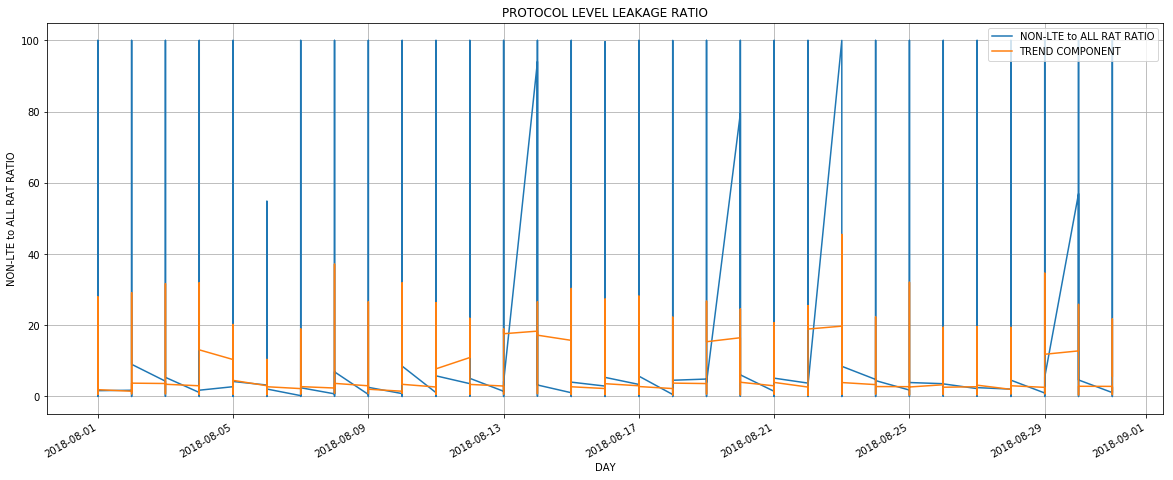

In [6]:
fig, ax = plt.subplots(figsize=(20,8))
plt.title('PROTOCOL LEVEL LEAKAGE RATIO')
plt.grid()
fig.autofmt_xdate()
plt.plot(df['DAY'], df['ratio'], label = 'NON-LTE to ALL RAT RATIO')
plt.plot(df['DAY'], trend, label='TREND COMPONENT')
plt.xlabel('DAY')
plt.ylabel('NON-LTE to ALL RAT RATIO')
plt.legend(loc='upper right')

#### Leakage Ratio and trend component from stl decomposition at National level

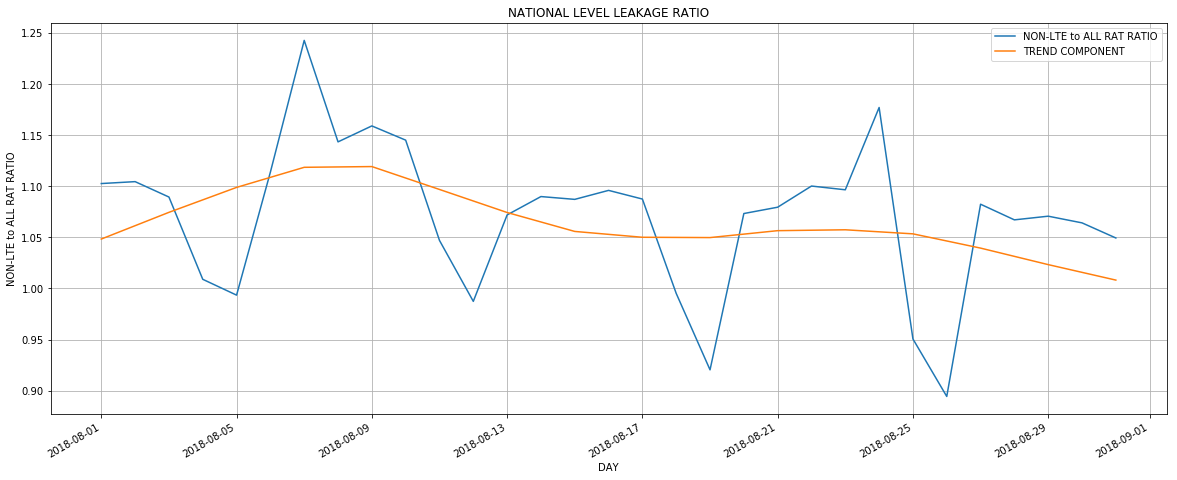

In [6]:
fig, ax = plt.subplots(figsize=(20,8))
plt.title('NATIONAL LEVEL LEAKAGE RATIO')
plt.grid()
fig.autofmt_xdate()
plt.plot(national_df['DAY'], national_df['ratio'], label = 'NON-LTE to ALL RAT RATIO')
plt.plot(national_df['DAY'], trend, label='TREND COMPONENT')
plt.xlabel('DAY')
plt.ylabel('NON-LTE to ALL RAT RATIO')
plt.legend(loc='upper right')

In [10]:
national_df['SEASONAL'] =season
national_df['IRREGULAR'] = resid
national_df['THRESHOLD'] = horiz_line_data

In [16]:
 national_df['IS_ANOMALY'] = ['YES' if i > j else 'NO' for i, j in zip(national_df['IRREGULAR'], national_df['THRESHOLD'])]

In [17]:
national_df.to_csv('national_level_ratio_stl_components.csv')

In [ ]:
national_dataset = pd.DataFrame({'Day':national_df['DAY'], 'Ratio':[]})

#### SEASONAL AND IRREGULAR COMPONENT AT NATIONAL LEVEL

In [7]:
deviation_line = np.mean(resid) + 1.5*(np.std(resid))
horiz_line_data = np.array([deviation_line for i in range(len(national_df['DAY']))])

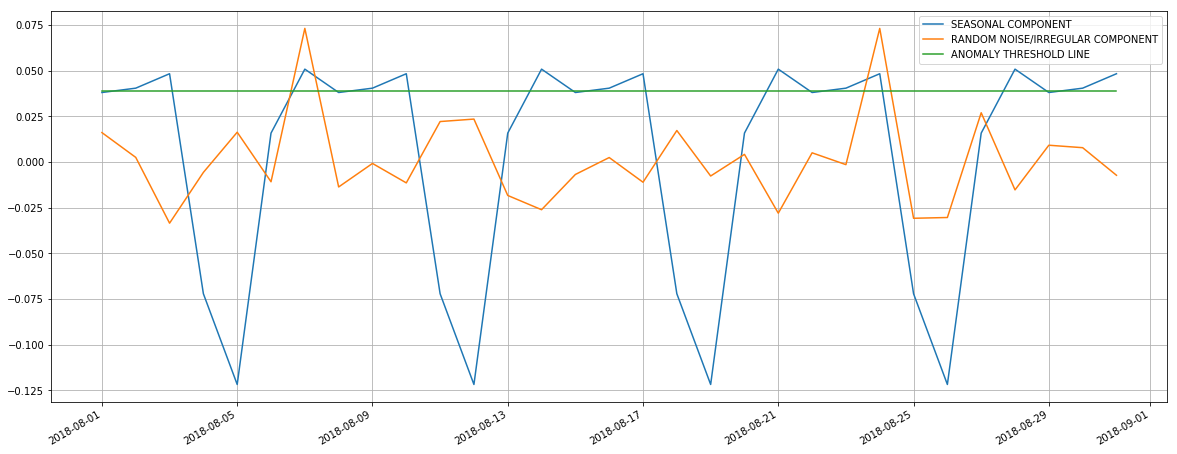

In [50]:
fig, ax = plt.subplots(figsize=(20,8))
plt.grid()
fig.autofmt_xdate()
plt.plot(national_df['DAY'], season, label='SEASONAL COMPONENT')
plt.plot(national_df['DAY'], resid, label='RANDOM NOISE/IRREGULAR COMPONENT')
plt.plot(national_df['DAY'], horiz_line_data, label='ANOMALY THRESHOLD LINE')
plt.legend(loc='upper right')

#### LEAKAGE RATIO AT DAY LEVEL ACROSS MARKETS

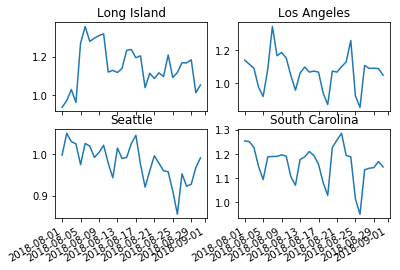

In [15]:
fig, ax = plt.subplots(nrows=2,ncols=2)
plt.title('Trends across Markets')
ax[0,0].plot(li_df['DAY'], li_df['ratio'])
ax[0,0].set_title('Long Island')
ax[0,1].plot(la_df['DAY'], la_df['ratio'])
ax[0,1].set_title('Los Angeles')
ax[1,0].plot(se_df['DAY'], se_df['ratio'])
ax[1,0].set_title('Seattle')
ax[1,1].plot(sc_df['DAY'], sc_df['ratio'])
ax[1,1].set_title('South Carolina')
fig.autofmt_xdate()

## Trend Seasonal and Irregular components of the leakage ratio across markets


#### LEAKAGE RATIO AND TREND COMPONENT OF LONG ISLAND

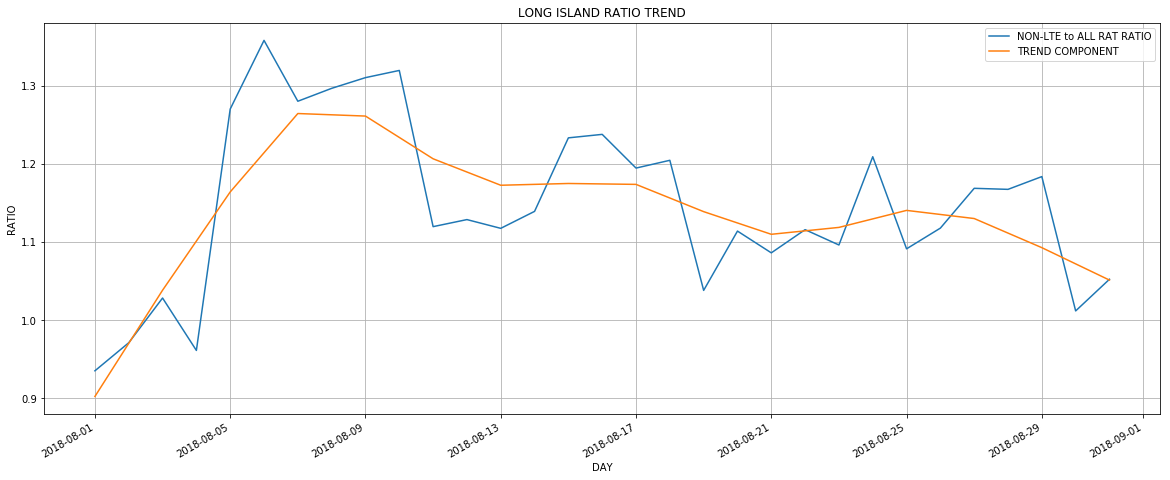

In [20]:
ts = li_df['ratio']
freq = 7

stl = STL(ts, freq, "periodic")

trend = stl.trend
season = stl.seasonal
resid = stl.remainder

fig, ax = plt.subplots(figsize=(20,8))
plt.grid()
fig.autofmt_xdate()
plt.plot(li_df['DAY'], li_df['ratio'], label = 'NON-LTE to ALL RAT RATIO')
plt.plot(li_df['DAY'], trend, label='TREND COMPONENT')
plt.title('LONG ISLAND RATIO TREND')
plt.xlabel('DAY')
plt.ylabel('RATIO')
plt.legend(loc='upper right')


In [22]:
deviation_line = np.mean(resid) + 1.5*(np.std(resid))
horiz_line_data = np.array([deviation_line for i in range(len(li_df['DAY']))])

#### SEASONAL AND IRREGULAR COMPONENT OF LONG ISLAND

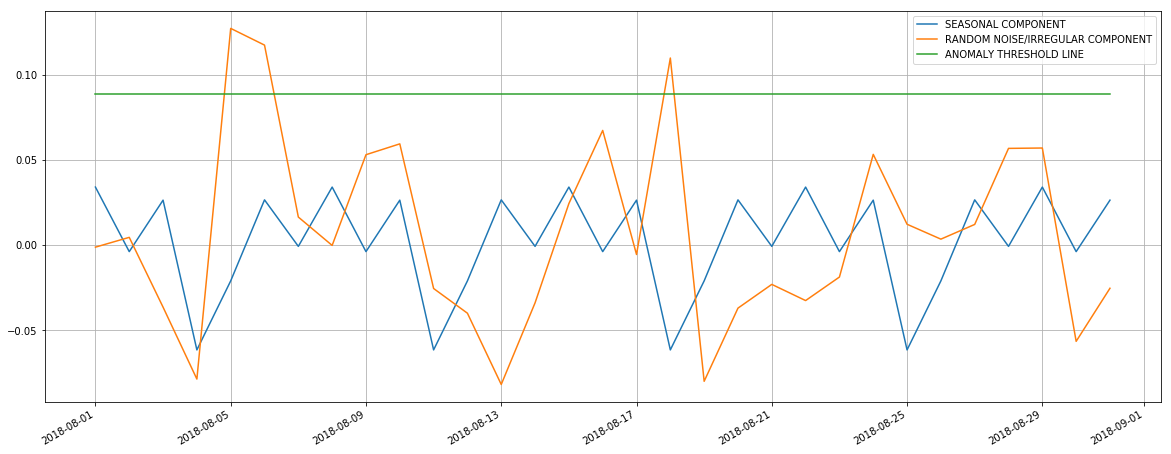

In [24]:
fig, ax = plt.subplots(figsize=(20,8))
plt.grid()
fig.autofmt_xdate()
plt.plot(li_df['DAY'], season, label='SEASONAL COMPONENT')
plt.plot(li_df['DAY'], resid, label='RANDOM NOISE/IRREGULAR COMPONENT')
plt.plot(li_df['DAY'], horiz_line_data, label='ANOMALY THRESHOLD LINE')
plt.legend(loc='upper right')

#### RATIO AND TREND COMPONENT OF LOS ANGELES

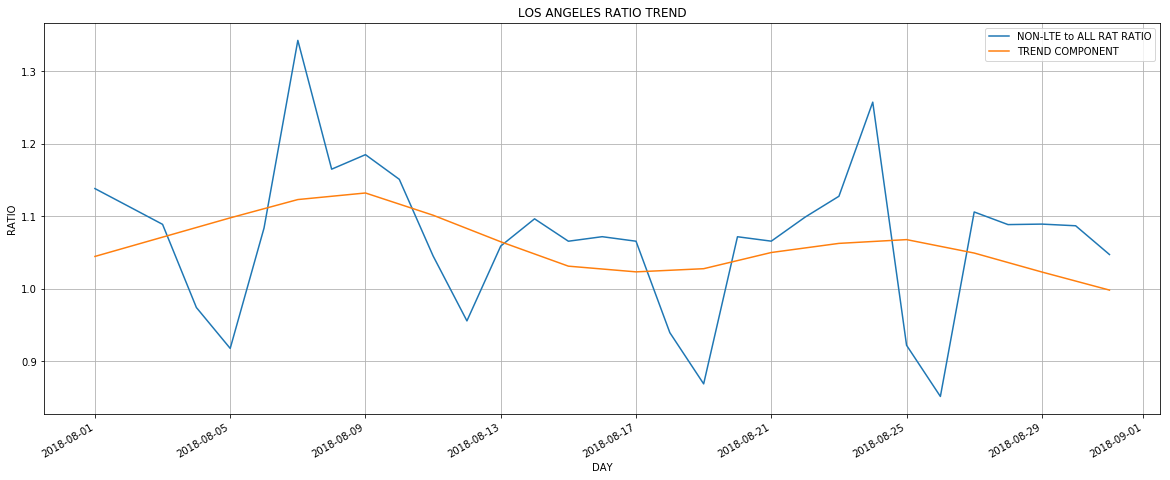

In [28]:
ts = la_df['ratio']
freq = 7

stl = STL(ts, freq, "periodic")

trend = stl.trend
season = stl.seasonal
resid = stl.remainder

fig, ax = plt.subplots(figsize=(20,8))
plt.grid()
fig.autofmt_xdate()
plt.plot(la_df['DAY'], la_df['ratio'], label = 'NON-LTE to ALL RAT RATIO')
plt.plot(la_df['DAY'], trend, label='TREND COMPONENT')
plt.title('LOS ANGELES RATIO TREND')
plt.xlabel('DAY')
plt.ylabel('RATIO')
plt.legend(loc='upper right')


In [26]:
deviation_line = np.mean(resid) + 1.5*(np.std(resid))
horiz_line_data = np.array([deviation_line for i in range(len(la_df['DAY']))])

#### SEASONAL AND IRREGULAR COMPONENT OF LOS ANGELES

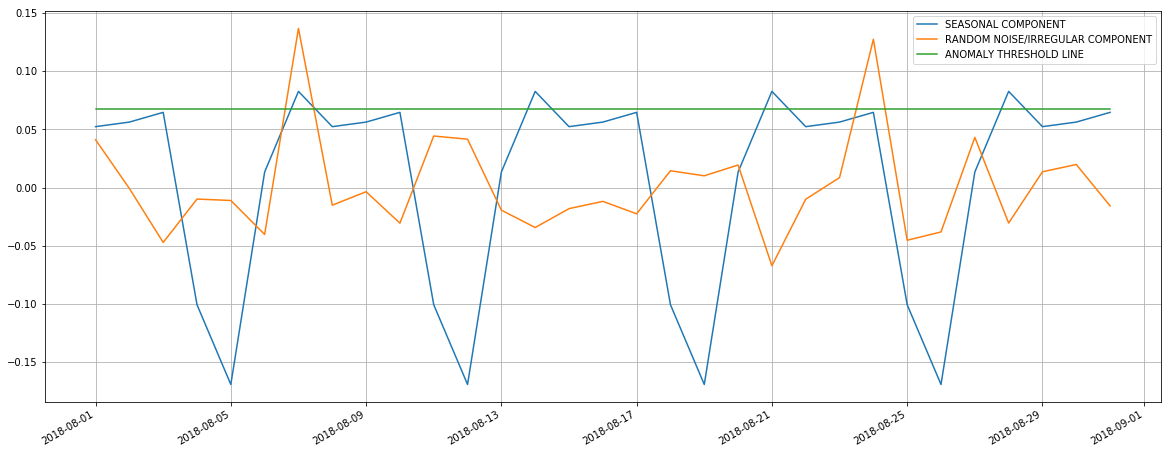

In [27]:
fig, ax = plt.subplots(figsize=(20,8))
plt.grid()
fig.autofmt_xdate()
plt.plot(la_df['DAY'], season, label='SEASONAL COMPONENT')
plt.plot(la_df['DAY'], resid, label='RANDOM NOISE/IRREGULAR COMPONENT')
plt.plot(la_df['DAY'], horiz_line_data, label='ANOMALY THRESHOLD LINE')
plt.legend(loc='upper right')

#### RATIO AND TREND COMPONENT OF SEATTLE

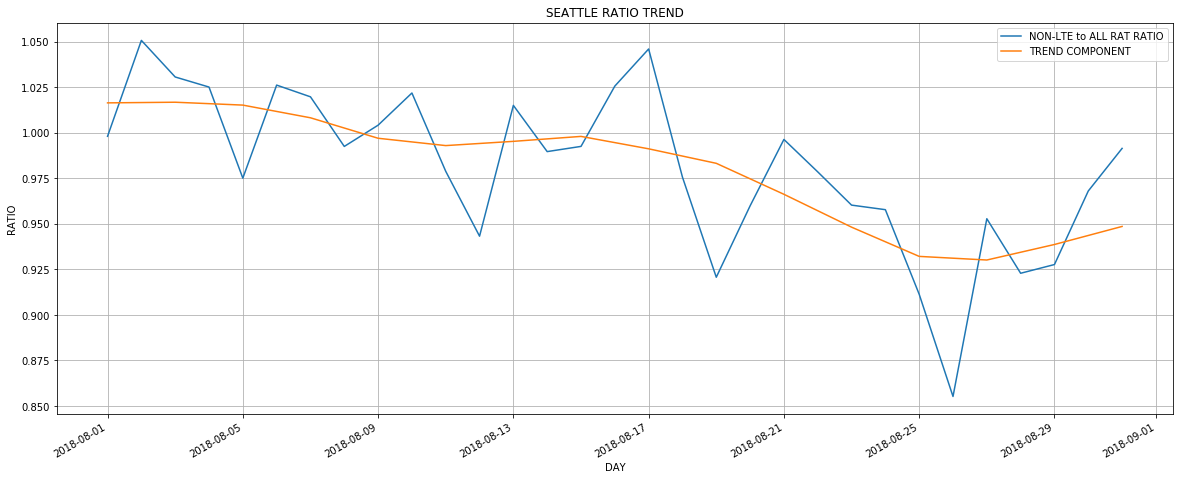

In [29]:
ts = se_df['ratio']
freq = 7

stl = STL(ts, freq, "periodic")

trend = stl.trend
season = stl.seasonal
resid = stl.remainder

fig, ax = plt.subplots(figsize=(20,8))
plt.grid()
fig.autofmt_xdate()
plt.plot(se_df['DAY'], se_df['ratio'], label = 'NON-LTE to ALL RAT RATIO')
plt.plot(se_df['DAY'], trend, label='TREND COMPONENT')
plt.title('SEATTLE RATIO TREND')
plt.xlabel('DAY')
plt.ylabel('RATIO')
plt.legend(loc='upper right')#plt.plot(li_df['DAY'], resid*10)
#plt.plot(li_df['DAY'], season)

In [30]:
deviation_line = np.mean(resid) + 1.5*(np.std(resid))
horiz_line_data = np.array([deviation_line for i in range(len(se_df['DAY']))])

#### SEASONAL AND IRREGULAR COMPONENT OF SEATTLE

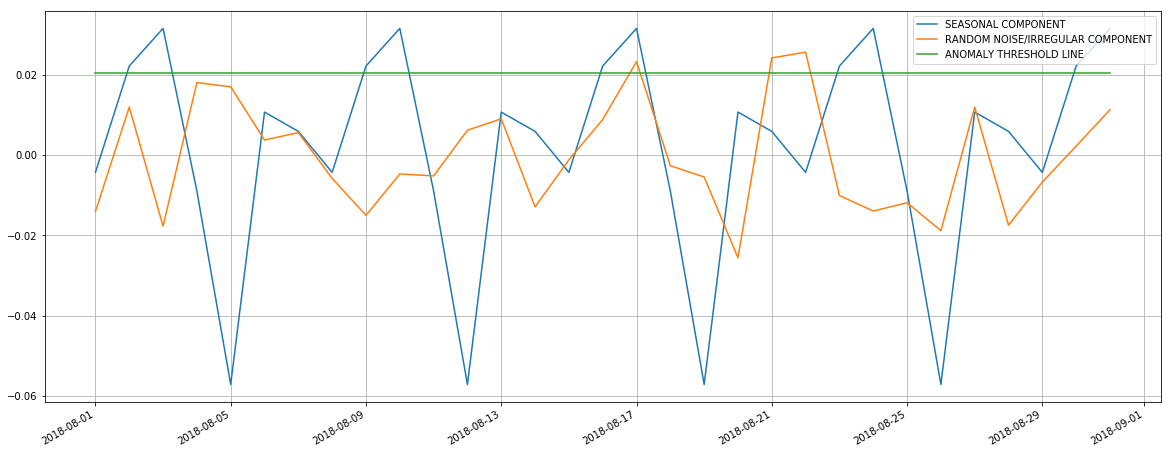

In [31]:
fig, ax = plt.subplots(figsize=(20,8))
plt.grid()
fig.autofmt_xdate()
plt.plot(se_df['DAY'], season, label='SEASONAL COMPONENT')
plt.plot(se_df['DAY'], resid, label='RANDOM NOISE/IRREGULAR COMPONENT')
plt.plot(se_df['DAY'], horiz_line_data, label='ANOMALY THRESHOLD LINE')
plt.legend(loc='upper right')

#### RATIO AND TREND COMPONENT OF SOUTH CAROLINA

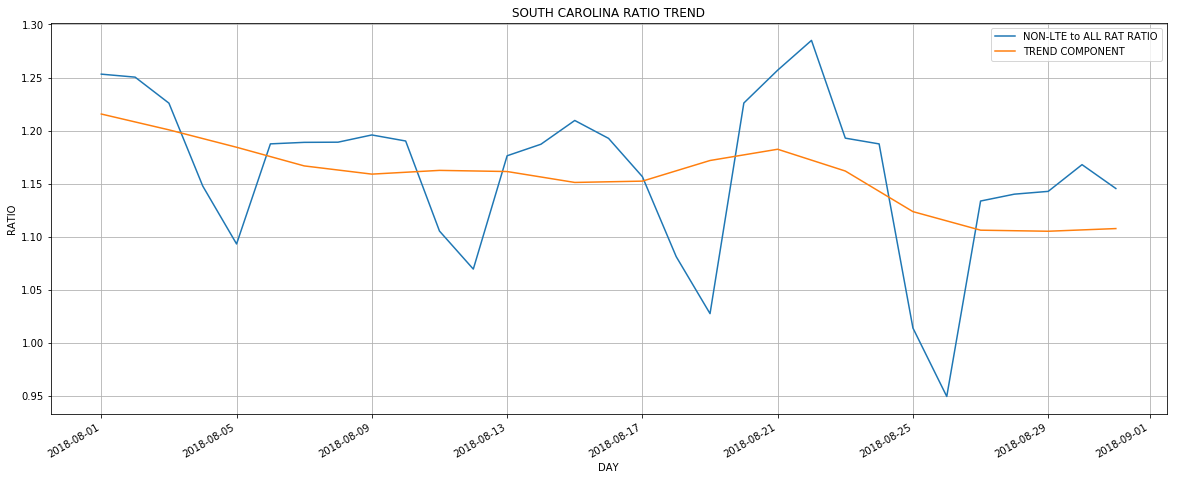

In [32]:
ts = sc_df['ratio']
freq = 7

stl = STL(ts, freq, "periodic")

trend = stl.trend
season = stl.seasonal
resid = stl.remainder

fig, ax = plt.subplots(figsize=(20,8))
plt.grid()
fig.autofmt_xdate()
plt.plot(sc_df['DAY'], sc_df['ratio'], label = 'NON-LTE to ALL RAT RATIO')
plt.plot(sc_df['DAY'], trend, label='TREND COMPONENT')
plt.title('SOUTH CAROLINA RATIO TREND')
plt.xlabel('DAY')
plt.ylabel('RATIO')
plt.legend(loc='upper right')#plt.plot(li_df['DAY'], resid*10)
#plt.plot(li_df['DAY'], sea
#plt.plot(li_df['DAY'], resid*10)
#plt.plot(li_df['DAY'], season)

In [33]:
deviation_line = np.mean(resid) + 1.5*(np.std(resid))
horiz_line_data = np.array([deviation_line for i in range(len(sc_df['DAY']))])

#### SEASONAL AND IRREGULAR COMPONENT OF SOUTH CAROLINA

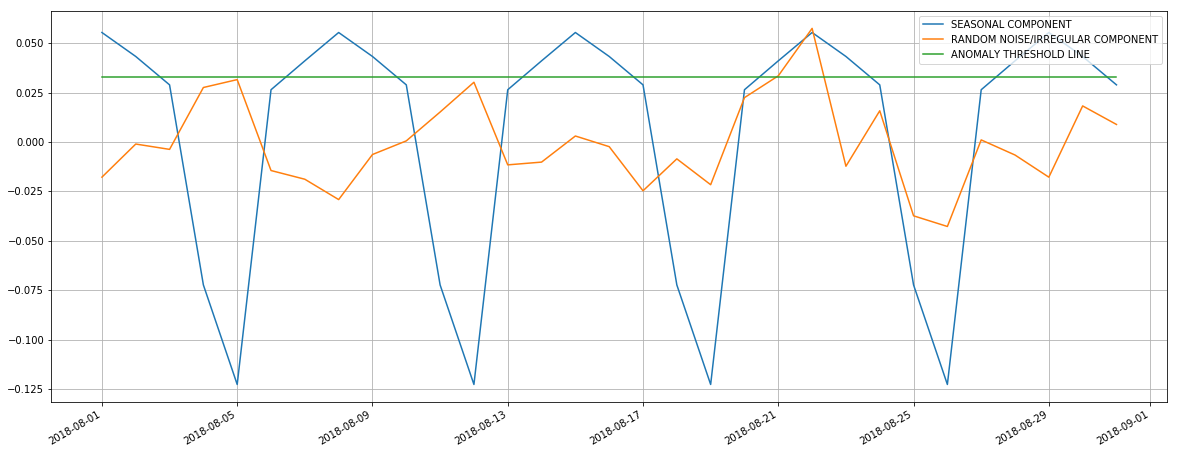

In [34]:
fig, ax = plt.subplots(figsize=(20,8))
plt.grid()
fig.autofmt_xdate()
plt.plot(sc_df['DAY'], season, label='SEASONAL COMPONENT')
plt.plot(sc_df['DAY'], resid, label='RANDOM NOISE/IRREGULAR COMPONENT')
plt.plot(sc_df['DAY'], horiz_line_data, label='ANOMALY THRESHOLD LINE')
plt.legend(loc='upper right')

#### OVERALL DAY LEVEL

Text(0.5, 1.0, 'DAY LEVEL Non-LTE to ALL RAT ratio')

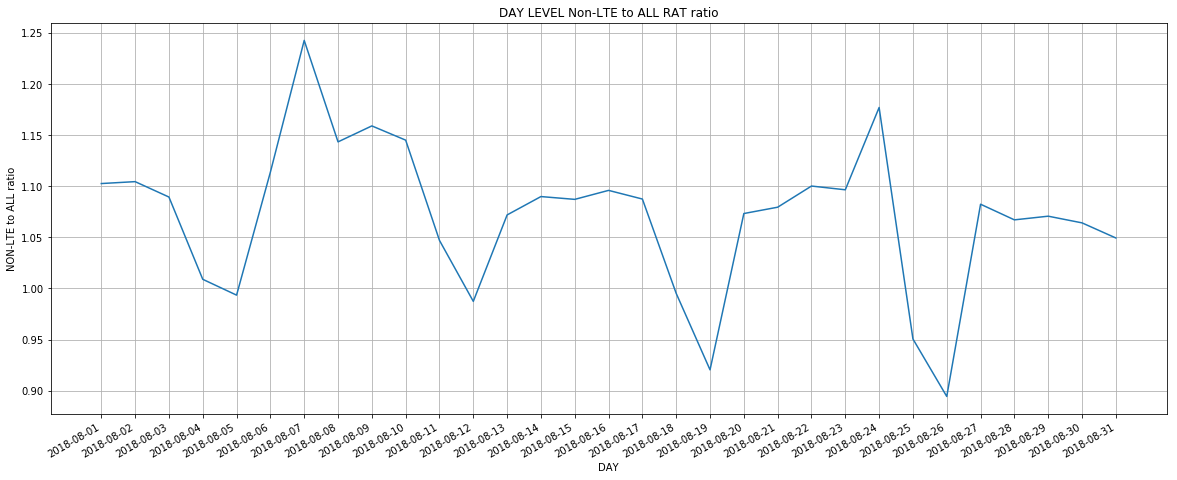

In [171]:
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(duration_df['DAY'], duration_df['ratio'])
plt.grid()
fig.autofmt_xdate()
plt.xlabel('DAY')
plt.ylabel('NON-LTE to ALL ratio')
plt.title('DAY LEVEL Non-LTE to ALL RAT ratio')